### **Classification using Sky Survey Cataloging**

##### **Goal**
- To predict class (star or galaxy) of sky objects, especially visually faint ones, based on the telescopic survey images (from Palomar Observatory). i.e., 3000 images with 23,040 x 23,040 pixels per image.

##### **Approach**
- [x] Search and retrieve relevant satellite data from a credible source.
- [X] Select relevant techniques to clean the data (missing values, outliers, wrong data types etc.)
- [X] Choose the correct feature selection technique for a classification problem.
- [x] Perform feature normalization on the data set.
- [ ] Segment the image.
- [ ] Measure image attributes (features) - 40 of them per object.
- [ ] Model the class based on these features.
- [ ] Success Story: Could find 16 new high red-shift quasars, some of the farthest objects that are difficult to find.

##### **About the Project**

The Sloan Digital Sky Survey has created the most detailed three-dimensional maps of the Universe ever made, with deep multi-color images of one third of the sky, and spectra for more than three million astronomical objects. 

The data was obtained from http://skyserver.sdss.org/dr16/en/home.aspx using the following SQL query:
```
SELECT TOP 10000
p.objid,p.ra,p.dec,p.u,p.g,p.r,p.i,p.z, p.run, p.rerun, p.camcol, p.field,
s.specobjid, s.class, s.z as redshift, s.plate, s.mjd, s.fiberid
FROM PhotoObj AS p
JOIN SpecObj AS s ON s.bestobjid = p.objid
WHERE
p.u BETWEEN 0 AND 19.6
AND g BETWEEN 0 AND 20
```

The dataset contains 18 features, most importantly:
- ra, dec — right ascension and declination respectively
- u, g, r, i, z — filter bands (a.k.a. photometric system or astronomical magnitudes)
- run, rerun, camcol, field — descriptors of fields (i.e. 2048 x 1489 pixels) within image
- class - classifies the object as star, galaxy, or quasar
- redshift — increase in wavelength due to motion of astronomical object
- plate — plate number
- mjd — modified Julian date of observation
- fiberid — optic fiber ID

##### **1. Import libraries and load data**

In [26]:
# import libraries

try:
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    from matplotlib import style
    import seaborn as sns
    from scipy import stats
    sns.set_style('whitegrid')
    import tensorflow as tf
    from sklearn.model_selection import train_test_split, cross_val_predict
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import SGDClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.naive_bayes import GaussianNB
    from sklearn.decomposition import PCA
    from xgboost import XGBClassifier
    from sklearn.preprocessing import LabelEncoder, MinMaxScaler, RobustScaler
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
    from sklearn.preprocessing import MaxAbsScaler
    from sklearn.model_selection import cross_val_score
    import time
    import warnings
except ImportError:
    print('Import(s) Unsuccessful')
except:
    print("Error: Something else went wrong.")
else:
    print('Import(s) successful')

warnings.filterwarnings("ignore")
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

Import(s) successful


In [3]:
# load the dataset into a dataframe
try:
    df = pd.read_csv('group7.csv')
except FileNotFoundError:
    print('File not found in the path')
except:
    print("Error: Something else went wrong.")
else:
    print('File loaded successfully')

df.sample(2)

File loaded successfully


,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,class,redshift,plate,mjd,fiberid
4628,1.237650e+18,245.449712,0.534581,18.62488,17.66600,17.34398,17.23047,17.20244,752,301,5,681,3.897350e+17,STAR,-0.000062,346,51693,633
977,1.237650e+18,24.597201,13.423144,18.71487,17.41558,16.82697,16.47143,16.26373,1035,301,2,125,4.796850e+17,GALAXY,0.075930,426,51882,187


##### **2. Exploratory Data Analysis**

a. Description of Data

In [4]:
# get a brief overview of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   objid      10000 non-null  float64
 1   ra         10000 non-null  float64
 2   dec        10000 non-null  float64
 3   u          10000 non-null  float64
 4   g          10000 non-null  float64
 5   r          10000 non-null  float64
 6   i          10000 non-null  float64
 7   z          10000 non-null  float64
 8   run        10000 non-null  int64  
 9   rerun      10000 non-null  int64  
 10  camcol     10000 non-null  int64  
 11  field      10000 non-null  int64  
 12  specobjid  10000 non-null  float64
 13  class      10000 non-null  object 
 14  redshift   10000 non-null  float64
 15  plate      10000 non-null  int64  
 16  mjd        10000 non-null  int64  
 17  fiberid    10000 non-null  int64  
dtypes: float64(10), int64(7), object(1)
memory usage: 1.4+ MB


None of the entries contain NaN values.

In [5]:
# check for unique values
df.nunique().to_frame()

,0
objid,1
ra,10000
dec,10000
u,9730
g,9817
r,9852
i,9890
z,9896
run,23
rerun,1


In [6]:
# view dataset statistical descriptions
df.describe()

,objid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,specobjid,redshift,plate,mjd,fiberid
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.237650e+18,175.529987,14.836148,18.619355,17.371931,16.840963,16.583579,16.422833,981.034800,301.0,3.648700,302.380100,1.645022e+18,0.143726,1460.986400,52943.533300,353.069400
std,0.000000e+00,47.783439,25.212207,0.828656,0.945457,1.067764,1.141805,1.203188,273.305024,0.0,1.666183,162.577763,2.013998e+18,0.388774,1788.778371,1511.150651,206.298149
min,1.237650e+18,8.235100,-5.382632,12.988970,12.799550,12.431600,11.947210,11.610410,308.000000,301.0,1.000000,11.000000,2.995780e+17,-0.004136,266.000000,51578.000000,1.000000
25%,1.237650e+18,157.370946,-0.539035,18.178035,16.815100,16.173333,15.853705,15.618285,752.000000,301.0,2.000000,184.000000,3.389248e+17,0.000081,301.000000,51900.000000,186.750000
50%,1.237650e+18,180.394514,0.404166,18.853095,17.495135,16.858770,16.554985,16.389945,756.000000,301.0,4.000000,299.000000,4.966580e+17,0.042591,441.000000,51997.000000,351.000000
75%,1.237650e+18,201.547279,35.649397,19.259232,18.010145,17.512675,17.258550,17.141447,1331.000000,301.0,5.000000,414.000000,2.881300e+18,0.092579,2559.000000,54468.000000,510.000000
max,1.237650e+18,260.884382,68.542265,19.599900,19.918970,24.802040,28.179630,22.833060,1412.000000,301.0,6.000000,768.000000,9.468830e+18,5.353854,8410.000000,57481.000000,1000.000000


In [7]:
# see number of values per class
df['class'].value_counts()

GALAXY    4998
STAR      4152
QSO        850
Name: class, dtype: int64

We see that 91.5% of the entries are either galaxies or stars. Quasars only make up 8.5% of the dataset.

In [8]:
# drop unwanted columns
df.drop(['objid', 'run', 'rerun', 'camcol', 'field', 'specobjid'], axis=1, inplace=True)

b. Bivariate and Multivariate Analysis

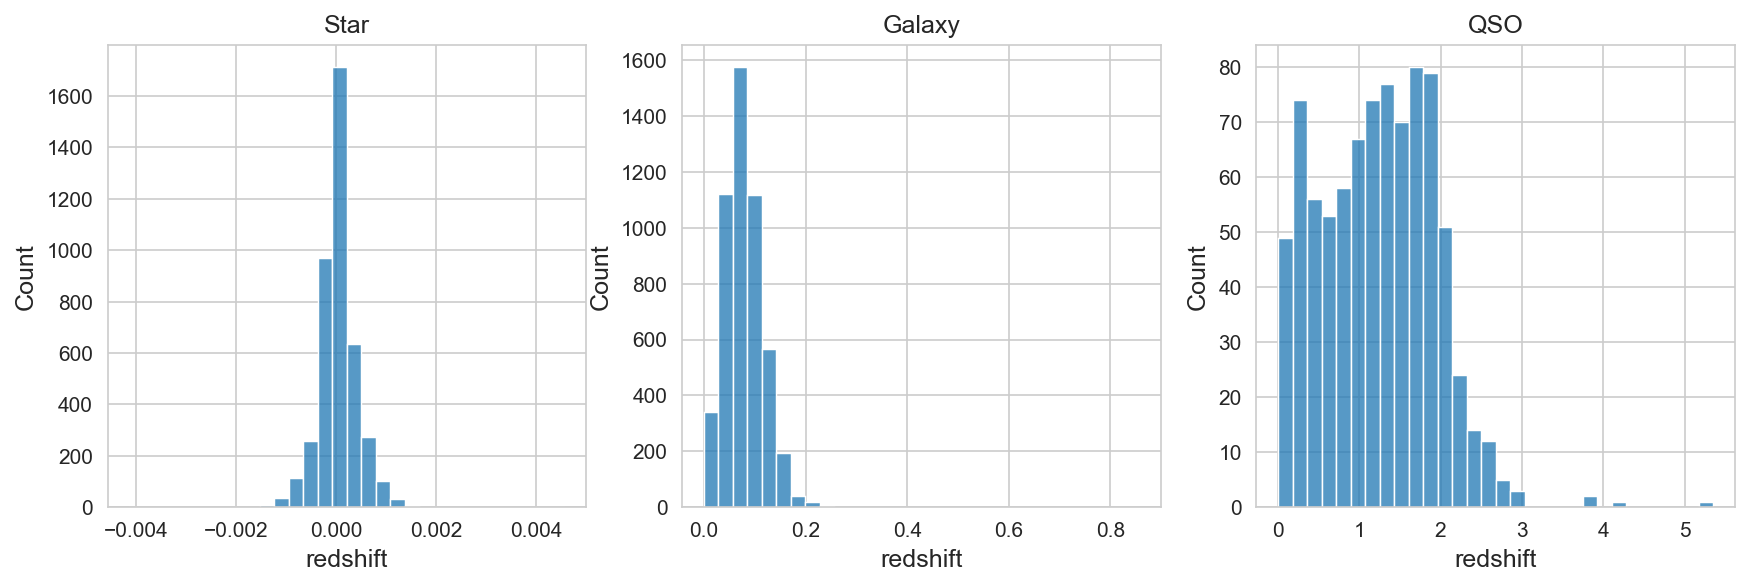

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(14, 4))
ax = sns.histplot(df[df['class']=='STAR'].redshift, bins = 30, ax = axes[0], kde = False, palette='p')
ax.set_title('Star')
ax = sns.histplot(df[df['class']=='GALAXY'].redshift, bins = 30, ax = axes[1], kde = False, palette='p')
ax.set_title('Galaxy')
ax = sns.histplot(df[df['class']=='QSO'].redshift, bins = 30, ax = axes[2], kde = False, palette='p')
ax = ax.set_title('QSO')

The histogram above tells us how the redshift values are distributed over their range.

Text(0.5, 1.0, 'dec')

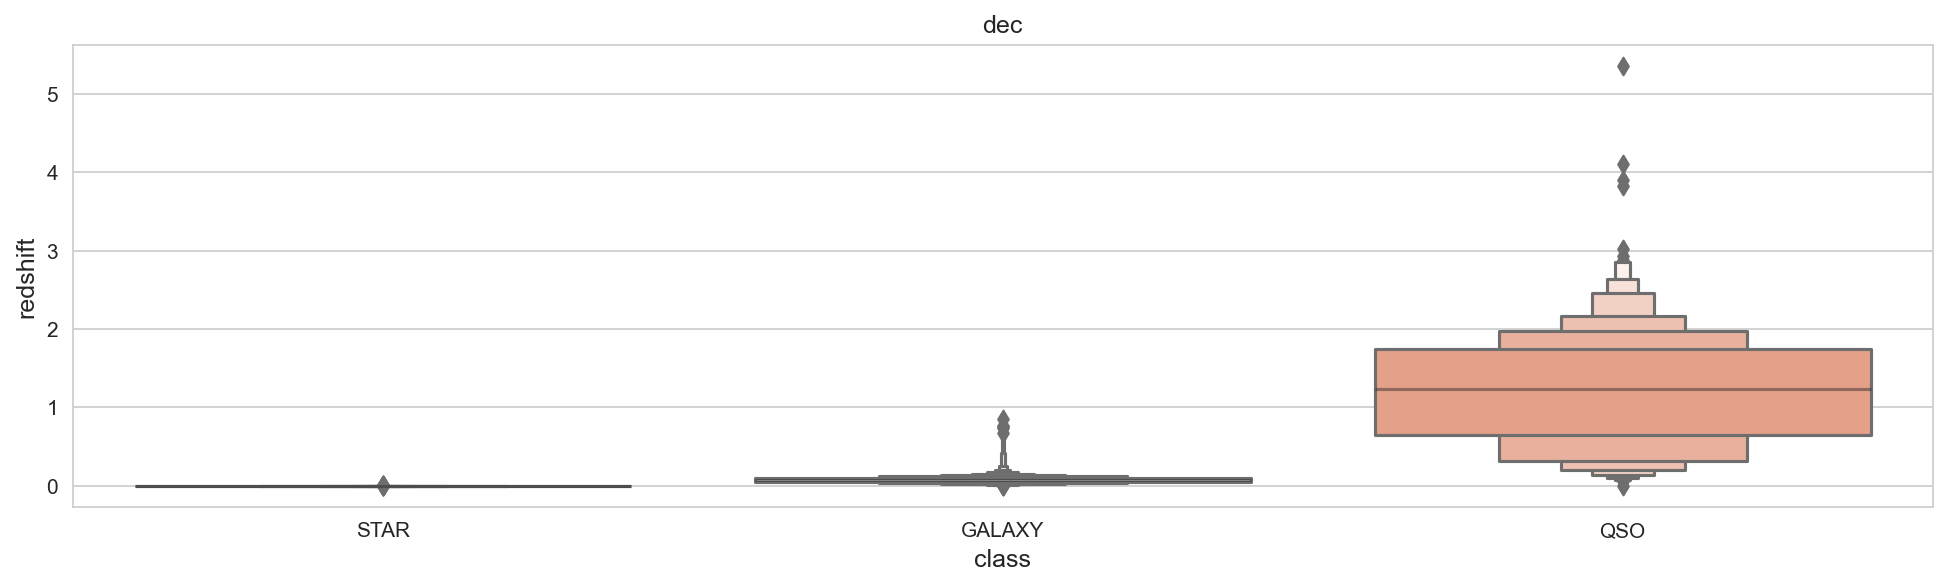

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 4))
ax = sns.boxenplot(x=df['class'], y=df['redshift'], palette='coolwarm')
ax.set_title('dec')

The redshift can be an estimate for the distance from the earth to a object in space.

Hence the plot above tells us that most of the stars observed are somewhat closer to the earth than galaxies or quasars. Galaxies tend to be a little further away and quasars are distant from very close to very far.

Text(0.5, 1.0, 'dec')

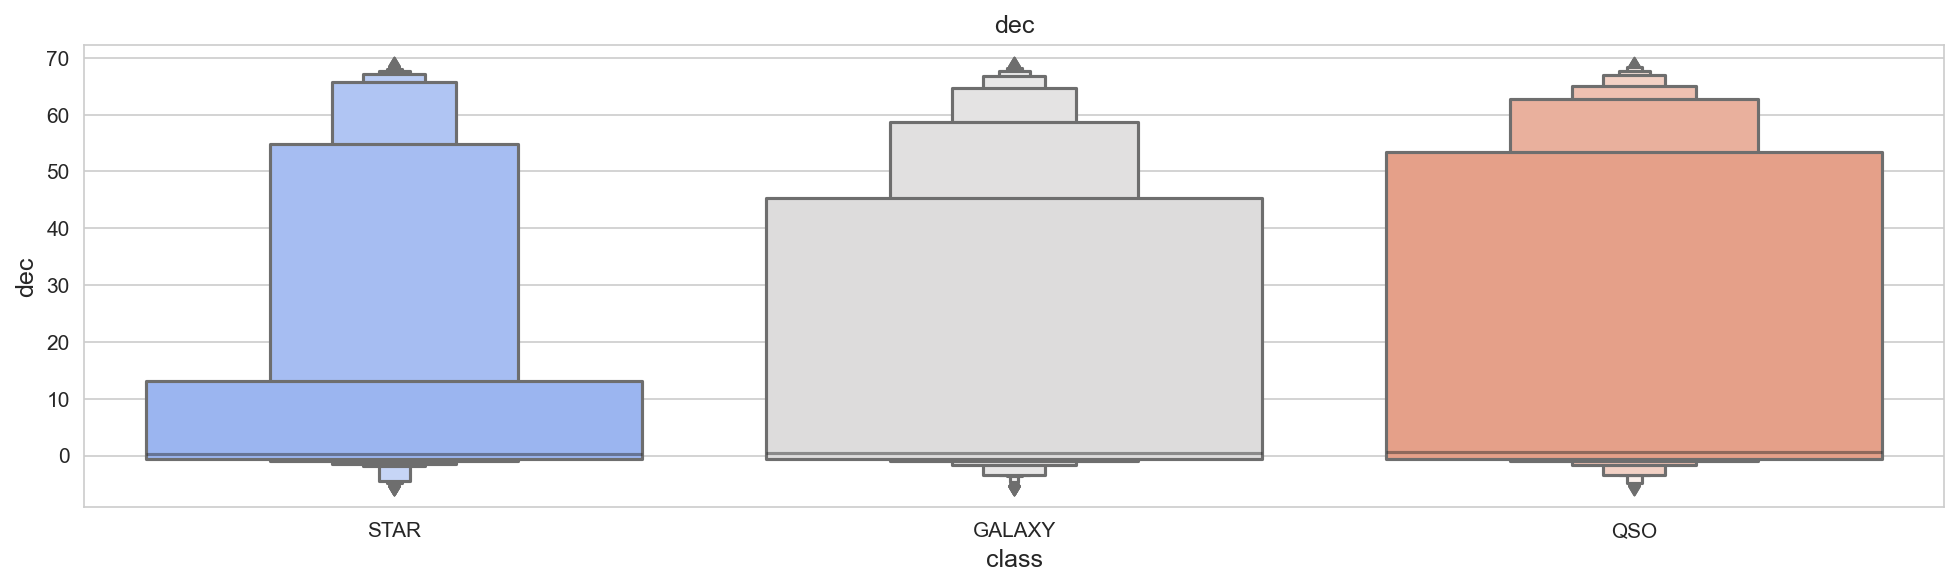

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 4))
ax = sns.boxenplot(x=df['class'], y=df['dec'], palette='coolwarm')
ax.set_title('dec')

The fact that the distribution of dec values of galaxies and quasar objects is almost the same might indicate that one can find both galaxies and quasars at smiliar positions in the night sky.

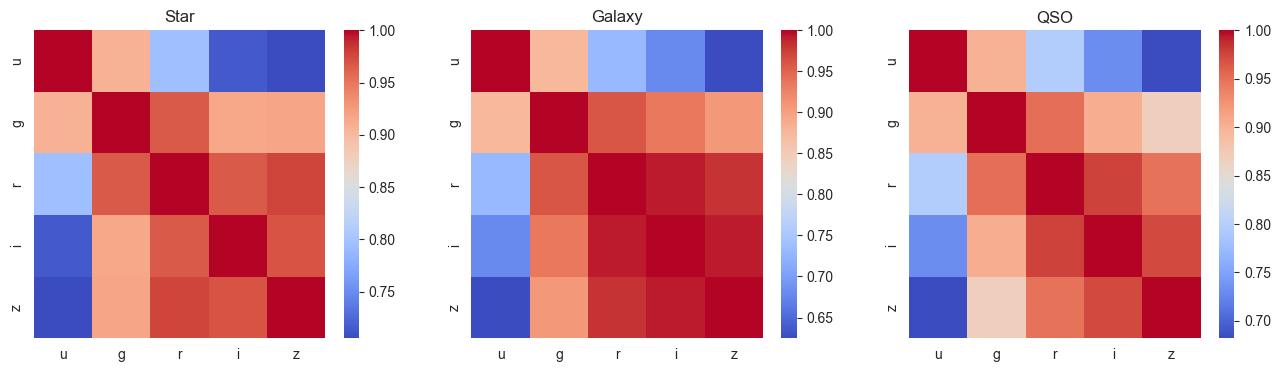

In [12]:
# correlation coefficients
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
fig.set_dpi(100)
ax = sns.heatmap(df[df['class']=='STAR'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[0], cmap='coolwarm')
ax.set_title('Star')
ax = sns.heatmap(df[df['class']=='GALAXY'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[1], cmap='coolwarm')
ax.set_title('Galaxy')
ax = sns.heatmap(df[df['class']=='QSO'][['u', 'g', 'r', 'i', 'z']].corr(), ax = axes[2], cmap='coolwarm')
ax = ax.set_title('QSO')

There are high correlations between the different bands.

Though, it is interesting to see that band 'u' is less correlated to the other bands.

Text(0.5, 1.0, 'Equatorial coordinates')

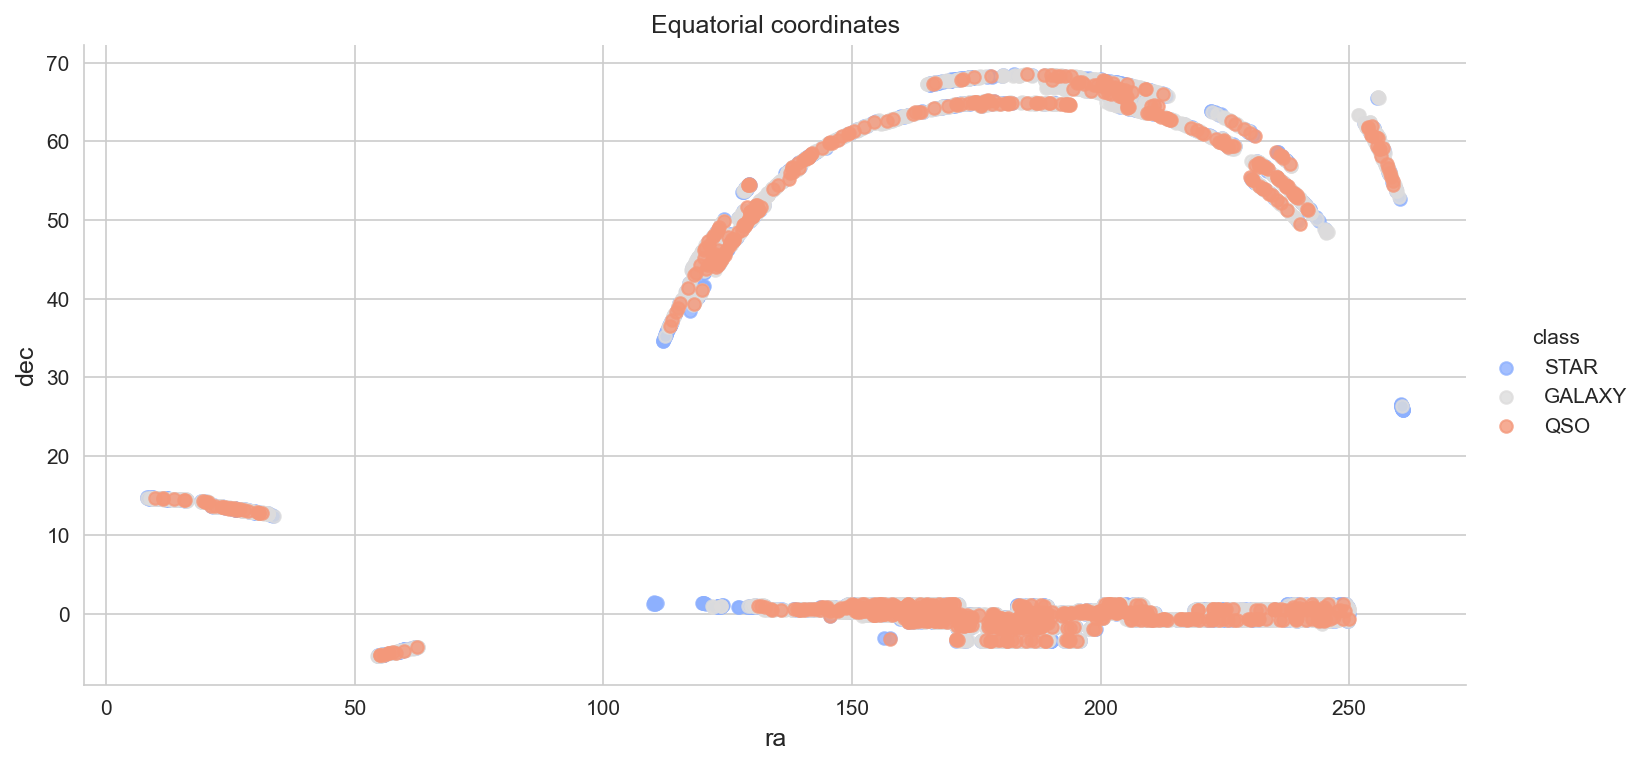

In [13]:
sns.lmplot(x='ra', y='dec', data=df, hue='class', fit_reg=False, palette='coolwarm', aspect=2)
plt.title('Equatorial coordinates')

There are some outliers for stars and galaxies.

Since all SDSS images cover the same area of the sky, we can say that the stars, galaxies, and quasars are observed equally at all coordinates.

##### **3. Feature Transformation**

Detecting and Removing Outliers

In [14]:
# change all numeric columns to float
df = df.astype(float, errors='ignore')

In [15]:
df2 = df.drop('class', axis=1)

In [16]:
Q1 = df2.quantile(0.25)
Q3 = df2.quantile(0.75)

IQR = Q3 - Q1

print(IQR)

ra            44.176333
dec           36.188432
u              1.081198
g              1.195045
r              1.339342
i              1.404845
z              1.523162
redshift       0.092498
plate       2258.000000
mjd         2568.000000
fiberid      323.250000
dtype: float64


In [17]:
x = (df2 < (Q1 - 1.5 * IQR)) | (df2 > (Q3 + 1.5 * IQR))

x.to_csv('data_iqr.csv')

Although there are some values that may be considered as outliers, none were removed.

Feature Normalization

In [18]:
df_fe = df

# encode class labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(df_fe['class'])
df_fe['class'] = y_encoded

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(df_fe[['u', 'g', 'r', 'i', 'z']])

# update dataframe 
sdss_df_fe = pd.concat((df_fe, pd.DataFrame(ugriz)), axis=1)
sdss_df_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
sdss_df_fe.drop(['u', 'g', 'r', 'i', 'z'], axis=1, inplace=True)
sdss_df_fe.head()

,ra,dec,class,redshift,plate,mjd,fiberid,PCA_1,PCA_2,PCA_3
0,183.531326,0.089693,2,-0.000009,3306.0,54922.0,491.0,-1.507202,-1.377293,-0.265119
1,183.598370,0.135285,2,-0.000055,323.0,51615.0,541.0,-0.195758,-0.028410,-0.155695
2,183.680207,0.126185,0,0.123111,287.0,52023.0,513.0,1.297604,-0.590023,0.140338
3,183.870529,0.049911,2,-0.000111,3306.0,54922.0,510.0,-1.446117,0.566685,-0.009272
4,183.883288,0.102557,2,0.000590,3306.0,54922.0,512.0,-0.849271,1.287505,-0.397689


In [19]:
# normalising the data using Robust Scaler
scaler = RobustScaler()
data = scaler.fit_transform(df_fe.drop('class', axis=1))

Robust scaler works best here because it is less sensitive to outliers as compared to other scalers such as the Standard scaler.

Split the dataset

In [20]:
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(data, df_fe['class'], test_size=0.33)

##### **4. Modelling and Prediction**

a. Random Forest

In [22]:
rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Accuracy of Random Forest: %3.2f" % (acc_rfc), "%")

Accuracy of Random Forest: 98.73 %


b. K-Nearest Neigbours (KNN)

In [23]:
knn = KNeighborsClassifier()
training_start = time.perf_counter()
knn.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = knn.predict(X_test)
prediction_end = time.perf_counter()
acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
knn_train_time = training_end-training_start
knn_prediction_time = prediction_end-prediction_start
print("Accuracy of KNN: %3.2f" % (acc_knn), "%")

Accuracy of KNN: 96.55 %


c. XGBoost

In [24]:
xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("Accuracy of Random Forest: %3.2f" % (acc_xgb), "%")

Accuracy of Random Forest: 98.94 %


##### **5. Compare Models**

In [25]:
results = pd.DataFrame({
    'Model': ['KNN', 'XGBoost', 'Random Forest'],
    'Score': [acc_knn, acc_xgb, acc_rfc,],
    })
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Score
Model,
XGBoost,98.939394
Random Forest,98.727273
KNN,96.545455


##### **6. K Fold Cross Validation**

In [27]:
# test the best model (XGBoost)
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.99104478 0.99402985 0.99104478 0.99104478 0.99701493 0.99253731
 0.98358209 0.98358209 0.99253731 0.99402985]
Mean: 0.991044776119403
Standard Deviation: 0.004114641418534397


XGBoost Further Evaluation

In [28]:
# get counts of the categorical class
unique, counts = np.unique(df_fe['class'], return_counts=True)
dict(zip(unique, counts))

{0: 4998, 1: 850, 2: 4152}

In [29]:
predictions = cross_val_predict(xgb, data, df_fe['class'], cv=3)
cf_matrix = confusion_matrix(df_fe['class'], predictions)
cf_matrix

array([[4964,   26,    8],
       [  48,  801,    1],
       [   4,    0, 4148]], dtype=int64)

<AxesSubplot:>

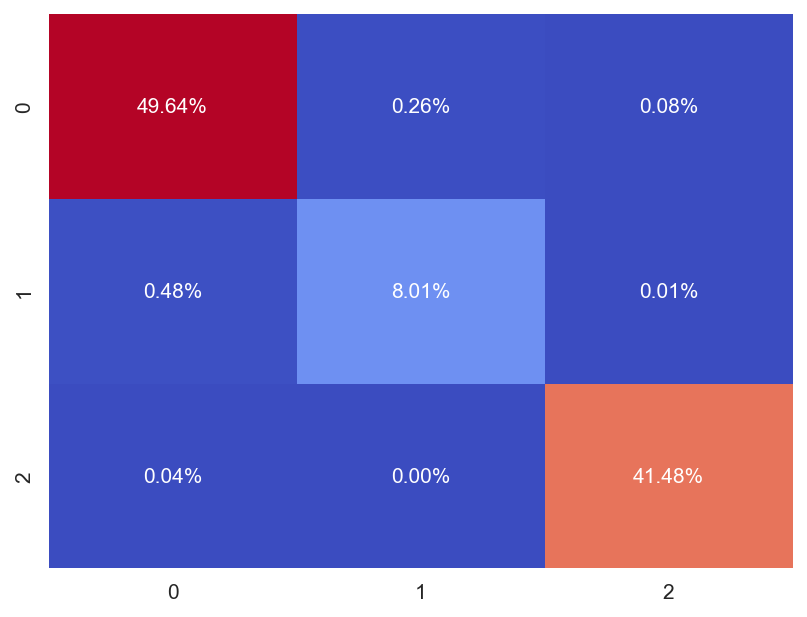

In [30]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='coolwarm', cbar=False)

In [31]:
print("Precision:", precision_score(df_fe['class'], predictions, average='micro'))
print("Recall:",recall_score(df_fe['class'], predictions, average='micro'))
print("F1-Score:", f1_score(df_fe['class'], predictions, average='micro'))

Precision: 0.9913
Recall: 0.9913
F1-Score: 0.9913
